<a href="https://www.kaggle.com/code/aabdollahii/bert-model-aigen-detection?scriptVersionId=280923230" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import re
import unicodedata
import pandas as pd 
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
from transformers import BertModel


2025-11-22 11:37:10.115992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763811430.303486      93 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763811430.356219      93 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [3]:
import re
import unicodedata

def preprocess_text(text):
    # 1. Basic Safety Check
    if not isinstance(text, str):
        return ""
    
    # 2. Unicode Normalization
    # This fixes weird characters (like "smart quotes" vs "straight quotes")
    # to a standard format so the model doesn't get confused by encoding.
    text = unicodedata.normalize('NFKC', text)
    
    # 3. Remove HTML tags (if any exist in the dataset)
    # This removes things like <br>, <div>, <p>
    text = re.sub(r'<.*?>', '', text)
    
    # 4. Handle Newlines and Escape Characters
    # You mentioned removing \n. We replace them with a SPACE.
    # This regex finds newlines (\n), tabs (\t), and carriage returns (\r)
    text = re.sub(r'[\r\n\t]+', ' ', text)
    
    # 5. Remove specific artifact tags (optional customization)
    # Sometimes datasets have artifacts like "[[uuid]]" or similar.
    # If you noticed specific ugly tags, add them here. 
    # For now, we clean extra backslashes that might be escape artifacts.
    text = text.replace('\\', '')

    # 6. Collapse multiple spaces into one
    # "Hello    world" -> "Hello world"
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


df['clean_text'] = df['text'].apply(preprocess_text)



In [4]:
df.head()

,text,label,prompt_name,source,RDizzl3_seven,clean_text
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,Phones Modern humans today are always on their...
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,This essay will explain if drivers should or s...
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,Driving while the use of cellular devices Toda...
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,Phones & Driving Drivers should not be able to...
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,Cell Phone Operation While Driving The ability...


# In the tokenization step, first I use the wordpieace method, no good results ? then use BPE.

In [5]:


# --- CONFIGURATION ---
MODEL_NAME = 'bert-base-cased'  # Using Cased to capture capitalization signals
MAX_LEN = 512
BATCH_SIZE = 16                 # Adjust based on your GPU RAM (8, 16, or 32).Good for kaggle env


class AI_Detection_Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Adds [CLS] and [SEP]
            max_length=self.max_len,      # Sets limit to 512
            return_token_type_ids=False,
            padding='max_length',         # Pads shorter sentences to 512
            truncation=True,              # Truncates longer sentences to 512
            return_attention_mask=True,
            return_tensors='pt',          # Returns PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def prepare_dataloaders(df):
    print(f"Loading Tokenizer: {MODEL_NAME}...")
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    
    df_train, df_val = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42, 
        stratify=df['label']
    )
    
    train_dataset = AI_Detection_Dataset(
        texts=df_train.clean_text.to_numpy(),
        labels=df_train.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    val_dataset = AI_Detection_Dataset(
        texts=df_val.clean_text.to_numpy(),
        labels=df_val.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    # --- THE FIX IS HERE ---
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=2,      # CHANGED FROM 0 TO 2 (Uses 2 CPU cores to prep data)
        pin_memory=True     # NEW: Speeds up transfer from RAM to GPU
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,      # CHANGED FROM 0 TO 2
        pin_memory=True     # NEW
    )
    
    return train_loader, val_loader

# Re-initialize the loaders
train_dataloader, val_dataloader = prepare_dataloaders(df)
print("Loaders optimized and ready.")


Loading Tokenizer: bert-base-cased...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loaders optimized and ready.


In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, model_name):
        super(BERTClassifier, self).__init__()
        
        # 1. Load the pre-trained BERT model
        # This downloads the weights from Hugging Face
        self.bert = BertModel.from_pretrained(model_name)
        
        # 2. Define the "Drop Out" layer
        # This randomly turns off 30% of neurons during training to prevent overfitting
        self.drop = nn.Dropout(p=0.3)
        
        # 3. Define the Output Layer (The Classification Head)
        # 768 is the standard output size of bert-base
        # 2 is the number of classes (Human vs AI)
        self.out = nn.Linear(in_features=768, out_features=2)
        
    def forward(self, input_ids, attention_mask):
        
        # output[0] = sequence_output (states for all tokens)
        # output[1] = pooled_output (a summary vector of the whole sentence)
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # We use pooled_output because we want a classification for the *whole* text
        pooled_output = output[1]
        
        #  Apply Dropout
        output = self.drop(pooled_output)
        
        #  Pass through the final layer to get scores for Human vs AI
        return self.out(output)

# --- INITIALIZATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = BERTClassifier(MODEL_NAME)
model = model.to(device)  # Move the entire model onto the GPU

print("Model initialized and moved to GPU successfully.")

Using device: cuda


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Model initialized and moved to GPU successfully.


In [7]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import numpy as np
from tqdm import tqdm

# --- HYPERPARAMETERS ---
EPOCHS = 3
LEARNING_RATE = 2e-5

# 1. Define Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 2. Define Loss Function
loss_fn = CrossEntropyLoss().to(device)

# --- TRAIN FUNCTION (Updated to use d['labels']) ---
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        # FIX: Your dataset uses 'labels', not 'targets'
        targets = d["labels"].to(device) 
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

# --- EVAL FUNCTION (Updated to use d['labels']) ---
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            # FIX: Your dataset uses 'labels', not 'targets'
            targets = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

# --- EXECUTE TRAINING ---
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

print("Starting training...")

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataloader.dataset) # Gets precise length
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(val_dataloader.dataset)
    )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    torch.save(model.state_dict(), 'bert_model_state.bin')


Starting training...
Epoch 1/3
----------


100%|██████████| 2244/2244 [37:39<00:00,  1.01s/it]


Train loss 0.04596849410558395 accuracy 0.9885217585111719
Val   loss 0.018951839609095737 accuracy 0.9952083797637621

Epoch 2/3
----------


100%|██████████| 2244/2244 [37:41<00:00,  1.01s/it]


Train loss 0.009152057859294873 accuracy 0.9980219535298379
Val   loss 0.014982730877941752 accuracy 0.996434143080009

Epoch 3/3
----------


100%|██████████| 2244/2244 [37:43<00:00,  1.01s/it]


Train loss 0.002085809821947447 accuracy 0.9995263832395387
Val   loss 0.025695181519913506 accuracy 0.9953198127925118



Generating predictions for evaluation...

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00      5474
     Class 1       0.99      1.00      0.99      3500

    accuracy                           1.00      8974
   macro avg       0.99      1.00      1.00      8974
weighted avg       1.00      1.00      1.00      8974



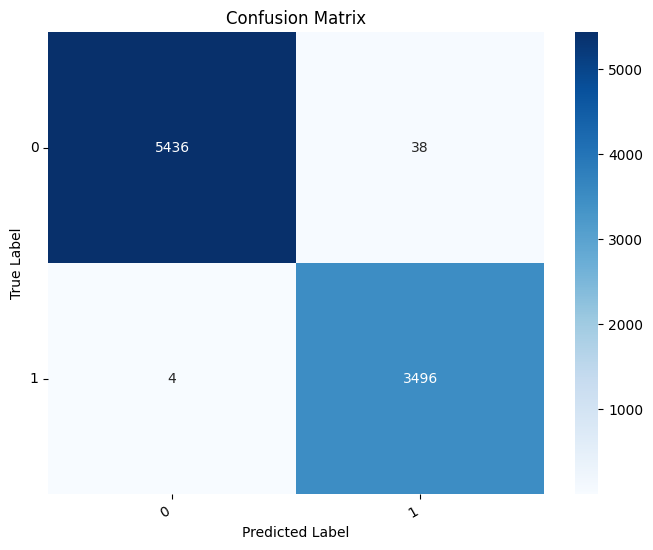

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return predictions, prediction_probs, real_values

# 1. Get predictions on Validation Set
print("Generating predictions for evaluation...")
y_pred, y_pred_probs, y_test = get_predictions(
    model,
    val_dataloader
)

# 2. Print Classification Report
print("\n--- Classification Report ---")
# Assuming 0=Human, 1=AI (or vice versa depending on your dataset setup)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# 3. Plot Confusion Matrix
def show_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm)


In [10]:
import torch
import torch.nn.functional as F
import re
import unicodedata

# 1. Define the EXACT preprocessing function used in training
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Unicode Normalization
    text = unicodedata.normalize('NFKC', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Handle Newlines/Tabs/Returns -> Single Space
    text = re.sub(r'[\r\n\t]+', ' ', text)
    
    # Remove backslashes
    text = text.replace('\\', '')

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 2. Define the Prediction Function wrapping the preprocessor
def predict_text(text, model, tokenizer, device):
    model.eval()
    
    # --- CRITICAL STEP: Apply the cleaning ---
    clean_text = preprocess_text(text)
    # -----------------------------------------
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        clean_text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs, dim=1)
        _, prediction = torch.max(outputs, dim=1)
    
    # Labels (0=Human, 1=AI based on standard DAIGT)
    class_name = "AI Generated 🤖" if prediction.item() == 1 else "Human Written 👤"
    
    # Get probability of the predicted class
    confidence = torch.max(probs).item()
    
    return class_name, confidence, clean_text

print("Updated Prediction Function (with preprocessing) is ready!")


Updated Prediction Function (with preprocessing) is ready!


In [12]:
from transformers import BertTokenizer

# 1. Reload the Tokenizer
print("Loading tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# 2. Run the Test again (Corrected for 3 return values)
print("\n--- TEST 1 ---")
# We add an underscore (_) to catch the 3rd value (clean text) and ignore it for now
label, conf, _ = predict_text(ai_sample, model, tokenizer, device)
print(f"Text: {ai_sample.strip()}")
print(f"Prediction: {label} | Confidence: {conf:.4f}\n")

print("--- TEST 2 ---")
label, conf, _ = predict_text(human_sample, model, tokenizer, device)
print(f"Text: {human_sample.strip()}")
print(f"Prediction: {label} | Confidence: {conf:.4f}")


Loading tokenizer...

--- TEST 1 ---
Text: In conclusion, the integration of artificial intelligence into daily life presents both significant challenges and remarkable opportunities. Furthermore, as technology advances, society must adapt to these changes to ensure a balanced future.
Prediction: AI Generated 🤖 | Confidence: 1.0000

--- TEST 2 ---
Text: I am not really confident about the results of works beccasue I recently done this job and detection was not really easy
Prediction: AI Generated 🤖 | Confidence: 0.9983


In [15]:
# A longer, clearly human-written paragraph (personal experience, opinionated)
long_human_sample = """
When considering the use of cattle at this particular site, analyses must be broadened to consider seasonality, and use of the cattle. Cattle at this time would have to graze during the spring summer and autumn, but the cattle would have no food source during the winter and thus, areas in the northern latitudes were very restricted in their exploitation of animals. (Dineley, M. 2006, pp. 56-62). During the early and middle of Neolithic time periods milk and cheese is thought to have been a symbolic currency for our ancestors (Dineley, M. 2006, pp. 56-62). However, during the Late Neolithic the importance of cattle came from their meat, especially in large animals such as cattle or hunted wild game such as aurochs. (Miracle, P. 2006, pp. 63-94) .

The % unfused increased in the latest fusion stages, indicating that the cattle were killed as they were older but before complete fusion (adulthood) had been reached during the Late Neolithic at Pupi´cina all of the major domestic animals were being herded primarily for meat (Miracle, P. 2006, pp. 63-94). Cattle appear to have been culled primarily for their meat towards the Late Neolithic time period (Miracle, P. 2006, pp. 63-94). However, Graph 1. indicated a kill of pattern of cattle as they got older. Looking at the age at deathL slaughter in infancy maximises availability of milk and cheese. Slaughter of juveniles or subadults maximises meat production and slater of adults indicates cattle beings used for labour (Isaakidou, V. 2006, pp. 95-112). Serjeantson mentions that there is evidence of this in the analysis of sherds from several Neolithic sites. The have shown “that dairy products were cooked or processed in some of the vessels” (Serjeantson, D. 2006, pp. 113-134).

Females vs Males
The productive potential of an animal is influenced partly by its age and sex (Isaakidou, V. 2006, pp. 95-112) Use of domestic cattle for primary carcass products was broadened to include the exploitation of secondary products in from the 4th-3rd millennia BC (Isaakidou, V. 2006, pp. 95-112). If you consider the evidence from Graph 1. Age classes that are evident in the cull need to be considered with the ratio of sexes surviving into adulthood.

The surviving cattle and their uses are thus reflected in the proportions of male and females (Legge, A.J. 1984, pp. 169-181). Males are known to have larger measurements than females. In Graph 2. Two groups can be identified, the first (in blue) with a smaller sixe measurement but quite numerous and the other group with a larger size and fewer cattle. This indicates a larger presence of female cattle and could indicate that the cattle at the site were indeed used for secondary products.
"""

print("--- TEST 3 (Longer Human Sample) ---")
label, conf, _ = predict_text(long_human_sample, model, tokenizer, device)
print(f"Text Length: {len(long_human_sample.split())} words")
print(f"Prediction:  {label}")
print(f"Confidence:  {conf:.4f}")


--- TEST 3 (Longer Human Sample) ---
Text Length: 450 words
Prediction:  Human Written 👤
Confidence:  0.9944


note : we have to give it a token near to 450 words. close to Bert model